In [119]:
from graphviz import Digraph
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
def with_label(value, label):
    value._label = label
    return value

class Value:
    def __init__(self, value, prev=(), op='', label=''):
        self._label = label
        self.data = value
        self._prev = set(prev)
        self._op = op
        self._grad = 0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        other = Value.get_value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self._grad += 1. * out.grad
            other._grad += 1. * out.grad
        out._backward = backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = Value.get_value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
            self._grad += other.data * out.grad
            other._grad += self.data * out.grad
        out._backward = backward

        return out

    def __rmul__(self, other):
        return self * other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self._grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int/float are supported on pow"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self._grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def backward():
            self._grad += (1 - t**2) * out.grad
        out._backward = backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def _build(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    _build(child)
                topo.append(v)

        _build(self)

        self._grad = 1
        for node in reversed(topo):
            node._backward()

    @staticmethod
    def get_value(x):
        if isinstance(x, Value):
            return x
        return Value(x, label=f'scalar({x})')

    @property
    def label(self):
        if not self._label and self._prev:
            return f"({[_n.label for _n in self._prev]})"
        return self._label

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op

    @property
    def grad(self):
        return self._grad

In [121]:
a = Value(2., label='a')
a + 1

Value(data=3.0, label=(['scalar(1)', 'a']))

In [122]:
2 * a

Value(data=4.0, label=(['a', 'scalar(2)']))

In [123]:
a.exp()

Value(data=7.38905609893065, label=(['a']))

In [124]:
a / 4

Value(data=0.5, label=(['scalar(0.25)', 'a']))

In [125]:
a - 1

Value(data=1.0, label=(['scalar(-1)', 'a']))

In [126]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for _n in nodes:
        uid = str(id(_n))
        dot.node(name = uid, label = "{ %s | %.4f | grad %.4f }" % (_n.label, _n.data, _n.grad), shape='record')
        if _n.op:
            dot.node(name = uid + _n.op, label = _n.op)
            dot.edge(uid + _n.op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

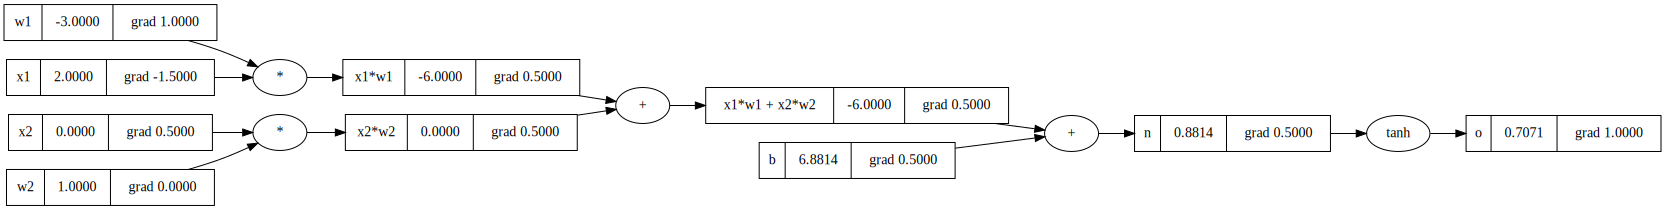

In [127]:
x1 = Value(2., label='x1') # input
x2 = Value(0., label='x2') # input
w1 = Value(-3., label='w1') # weight
w2 = Value(1., label='w2') # weight
b = Value(6.881373, label='b') # bias
x1w1 = with_label(x1 * w1, label='x1*w1')
x2w2 = with_label(x2 * w2, label='x2*w2')
x1w1x2w2 = with_label(x1w1 + x2w2, label='x1*w1 + x2*w2')
n = with_label(x1w1x2w2 + b, label='n')
o = with_label(n.tanh(), label='o')
o.backward()
draw_dot(o)

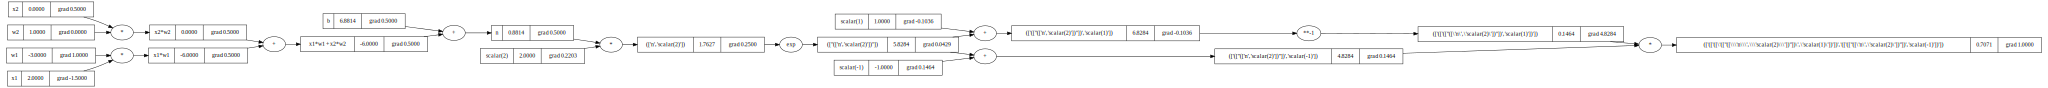

In [128]:
x1 = Value(2., label='x1') # input
x2 = Value(0., label='x2') # input
w1 = Value(-3., label='w1') # weight
w2 = Value(1., label='w2') # weight
b = Value(6.881373, label='b') # bias
x1w1 = with_label(x1 * w1, label='x1*w1')
x2w2 = with_label(x2 * w2, label='x2*w2')
x1w1x2w2 = with_label(x1w1 + x2w2, label='x1*w1 + x2*w2')
n = with_label(x1w1x2w2 + b, label='n')
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.backward()
draw_dot(o)